<a href="https://colab.research.google.com/github/Arguimbau/Countries/blob/main/Veggies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import itertools
import random
import os

In [60]:
!git clone https://github.com/joneikholmkea/veggies.git

fatal: destination path 'veggies' already exists and is not an empty directory.


In [74]:
trainingFiles = "veggies/trainRed"
testFiles = "veggies/testRed"
validationFiles = 'veggies/validation'
targetSize=[100,100]

In [75]:
image_files = glob(trainingFiles + '/*/*.jp*g') # load alle billeder som slutter med jpg eller jpeg
folders = glob(trainingFiles + '/*') # giver alle undermapper

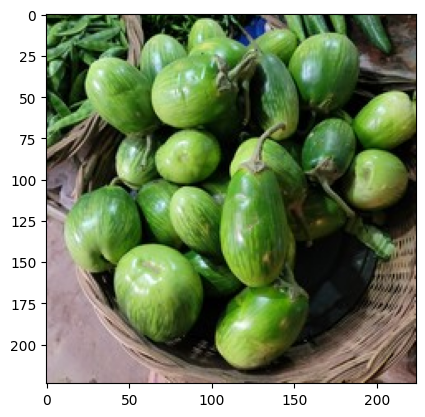

In [116]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [77]:
resNet= ResNet50(input_shape=targetSize + [3], weights='imagenet', include_top=False)

In [78]:
for layer in resNet.layers: #kun vores del af modellen skal trænes
  layer.trainable = False

In [244]:
# Add dropout to the model
layers = Flatten()(resNet.output)
layers = Dense(30, activation='relu')(layers)
layers = Dropout(0.2)(layers) # with 20% probability drop a neuron
layers = Dense(30, activation='relu')(layers)
layers = Dense(30, activation='relu')(layers)
layers = Dropout(0.2)(layers)
layers = Dense(len(folders), activation='softmax')(layers)

In [245]:
model = Model(inputs=resNet.input, outputs=layers)
model.compile(
    optimizer = 'adam',
    metrics=['accuracy'],
    loss='sparse_categorical_crossentropy'
)

In [246]:
# Create an instance of the ImageDataGenerator class
dataGen = ImageDataGenerator(
    rotation_range = 20,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.1,  # Set range for random shear
    zoom_range=0.2,  # Set range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    vertical_flip=True,  # Randomly flip inputs vertically
    preprocessing_function = preprocess_input  # Function applied to each input image
)

In [247]:
# Use the ImageDataGenerator instance to read images from the directory and preprocess them
training_set = dataGen.flow_from_directory(
    trainingFiles,  # Path to the directory
    target_size = targetSize,  # The dimensions to which all images found will be resized
    shuffle=True,  # Whether to shuffle the data
    batch_size=50,  # Number of images to process at a time
    class_mode='sparse'  # Mode for yielding the targets: 'sparse' means that the categorical labels will be returned as 1D integer labels
)

Found 3000 images belonging to 15 classes.


In [248]:
test_set = dataGen.flow_from_directory(
    testFiles,
    target_size = targetSize,
    shuffle=True,
    batch_size=50,
    class_mode='sparse' # Laver One-hot om til tal
)

Found 3000 images belonging to 15 classes.


In [249]:
validation_Set = dataGen.flow_from_directory(
    validationFiles,
    target_size = targetSize,
    shuffle=False,
    batch_size=50,
    class_mode='sparse' # Laver One-hot om til tal
)

Found 3000 images belonging to 15 classes.


In [250]:
model.fit(
    training_set,
    validation_data=validation_Set, #bruger test_set som guide til at burdere om vægte justeres optimalt
    epochs=5
)
model.save('my_model.keras')

Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 776ms/step - accuracy: 0.1081 - loss: 2.7174 - val_accuracy: 0.3483 - val_loss: 1.9004
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 716ms/step - accuracy: 0.2979 - loss: 2.0826 - val_accuracy: 0.4727 - val_loss: 1.6684
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 47s 778ms/step - accuracy: 0.3846 - loss: 1.8851 - val_accuracy: 0.5593 - val_loss: 1.4059
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 596ms/step - accuracy: 0.4263 - loss: 1.7543 - val_accuracy: 0.5897 - val_loss: 1.3007
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 634ms/step - accuracy: 0.4836 - loss: 1.5927 - val_accuracy: 0.6363 - val_loss: 1.1318


In [253]:
subfolders = [f.path for f in os.scandir(testFiles) if f.is_dir()]

# Choose a random subfolder
random_subfolder = random.choice(subfolders)

# Get a list of all images in the chosen subfolder
images = [f for f in os.listdir(random_subfolder) if os.path.isfile(os.path.join(random_subfolder, f))]

# Choose a random image
random_image = random.choice(images)
# Construct the full path to the random image
image_path = os.path.join(random_subfolder, random_image)

print("Chosen image path:", image_path)

# Load the image
img = image.load_img(image_path, target_size=(100, 100))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Expand dimensions to fit the model's expected input shape
img_array = np.expand_dims(img_array, axis=0)

# Normalize the image data
img_array /= 255.0

# Make a prediction
result = model.predict(img_array)

print("Prediction:", result)
# Get the index of the highest probability
predicted_class_index = np.argmax(result)

class_names = list(training_set.class_indices.keys())  # Replace this with your list of class names
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print("Predicted Class Name:", predicted_class_name)

Chosen image path: veggies/testRed\Bean\0512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: [[0.04665576 0.22179458 0.03448377 0.09887161 0.1587986  0.02890937
  0.06372688 0.01435167 0.03843752 0.04704109 0.06461269 0.02343108
  0.05914044 0.02694192 0.07280301]]
Predicted Class Name: Bitter_Gourd
